In [5]:
# WRITTEN BY ALAN LI
# NASA AMES LABORATORY FOR ADVANCED SENSING (LAS)
# Last edited: Oct 2, 2017

import sys
import random
import numpy as np
import cv2
import tensorflow as tf
import glob
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter
import pandas as pd
import logging
import keras
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.initializers import RandomNormal, TruncatedNormal
from keras.optimizers import SGD
from keras import losses
from keras import backend as K

# Config the matplotlib backend as plotting in line in IPython
%matplotlib notebook

In [2]:
def load_data(Imagepath, Truthpath, truth_key = None):
    # Load images
    img1 = cv2.imread(Imagepath,cv2.IMREAD_UNCHANGED)
    img1_truth = cv2.imread(Truthpath,cv2.IMREAD_UNCHANGED)

    # Set labels from 0 to item_counter based upon input truth_key
    if truth_key is not None:
        item_counter = 0
        for item in truth_key:
            img1_truth[img1_truth == item ] = item_counter  # Sand
            item_counter+=1
    return img1, img1_truth

#### Normalize Image
'''Input:
    dataset: set of vectorized images, N_images x nrow x ncol x n_channels
    depth: pixel depth, float
Output:
    dataset_norm: set of vectorized normalized images, N_images x nrow x ncol x n_channels'''
def rescale(dataset, depth):
    dataset_norm = (dataset.astype(np.float32) - depth/2)/(depth/2)
    return dataset_norm

#### Randomize set of data
'''Input:
    dataset: set of images, N_images x (nrow*ncol) x n_channels
    labels: set of labels, N_images x N_labels x num_labels 
Output:
    shuffled_dataset: set of randomized images, N_images x nrow x ncol x (n_channels-n_toremove)
    shuffled_labels: set of randomized labels, N_images x N_labels
'''
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:,:]
    shuffled_labels = labels[permutation,:]
    return shuffled_dataset, shuffled_labels   

#### Generate training data as randomized
def generate_training(WholeImage, TruthImage, image_size=25, N_train=20000, N_valid = 2500, N_test = 2500, 
                      toremove = False, figureson = False):
    num_labels = len(np.unique(TruthImage))
    crop_len = int(np.floor(image_size/2))
    Truth_crop = TruthImage[crop_len:TruthImage.shape[0]-crop_len, crop_len:TruthImage.shape[1]-crop_len]
    
    # Randomly select points
    train_datasets = []
    train_labels = []
    valid_datasets = []
    valid_labels =[]
    test_datasets = []
    test_labels = []
    
    for k in range(num_labels):
        [i,j] = np.where(Truth_crop == k)
        # Training set
        idx = np.asarray(random.sample(range(len(i)), N_train)).astype(int)
        train_datasets.append([WholeImage[i[idx[nn]]:i[idx[nn]]+image_size, j[idx[nn]]:j[idx[nn]]+image_size, :] for nn in range(len(idx))])
        train_labels.append([Truth_crop[i[idx[nn]], j[idx[nn]]] for nn in range(len(idx))])
        # Validation set
        idx = np.asarray(random.sample(range(len(i)), N_valid)).astype(int)
        valid_datasets.append([WholeImage[i[idx[nn]]:i[idx[nn]]+image_size, j[idx[nn]]:j[idx[nn]]+image_size, :] for nn in range(len(idx))])
        valid_labels.append([Truth_crop[i[idx[nn]], j[idx[nn]]] for nn in range(len(idx))])
        # Test set
        idx = np.asarray(random.sample(range(len(i)), N_test)).astype(int)
        test_datasets.append([WholeImage[i[idx[nn]]:i[idx[nn]]+image_size, j[idx[nn]]:j[idx[nn]]+image_size, :] for nn in range(len(idx))])
        test_labels.append([Truth_crop[i[idx[nn]], j[idx[nn]]] for nn in range(len(idx))])
        
    # Some array handling and reshaping
    train_datasets = np.asarray(train_datasets) # train_datasets is in the format of num_labels x N_train x nrows x ncols x n_channels
    train_labels = np.asarray(train_labels) # train_labels is in the format of num_labels x N_train
    valid_datasets = np.asarray(valid_datasets)
    valid_labels = np.asarray(valid_labels) 
    test_datasets = np.asarray(test_datasets) 
    test_labels = np.asarray(test_labels)
    
    train_datasets = train_datasets.reshape(num_labels*N_train, image_size, image_size, WholeImage.shape[-1]) # flatten first 2 dimensions of train_datasets
    train_labels = train_labels.reshape(num_labels*N_train,1) # flatten into vector
    valid_datasets = valid_datasets.reshape(num_labels*N_valid, image_size, image_size, WholeImage.shape[-1]) 
    valid_labels = valid_labels.reshape(num_labels*N_valid,1) 
    test_datasets = test_datasets.reshape(num_labels*N_test, image_size, image_size, WholeImage.shape[-1]) 
    test_labels = test_labels.reshape(num_labels*N_test,1)
    
    if toremove is not None:
        train_datasets = np.delete(train_datasets,toremove,-1) # Remove specific last dimension of array
        valid_datasets = np.delete(valid_datasets,toremove,-1) # Remove specific last dimension of array
        test_datasets = np.delete(test_datasets,toremove,-1) # Remove specific last dimension of y
    
    # Plot sample images of different classes
    if figureson:
        plt.figure()
        for i in range(num_labels):
            plt.axis("off")
            plt.subplot(1, num_labels, i+1)
            plt.imshow(cv2.cvtColor(train_datasets[i*N_train,:,:,0:3], cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

    train_datasets, train_labels = randomize(train_datasets, train_labels)
    valid_datasets, valid_labels = randomize(valid_datasets, valid_labels)
    test_datasets, test_labels = randomize(test_datasets, test_labels)
    
    train_datasets = rescale(train_datasets, 255)
    valid_datasets = rescale(valid_datasets, 255) 
    test_datasets = rescale(test_datasets, 255)
    
    return train_datasets, train_labels, valid_datasets, valid_labels, test_datasets, test_labels

<IPython.core.display.Javascript object>


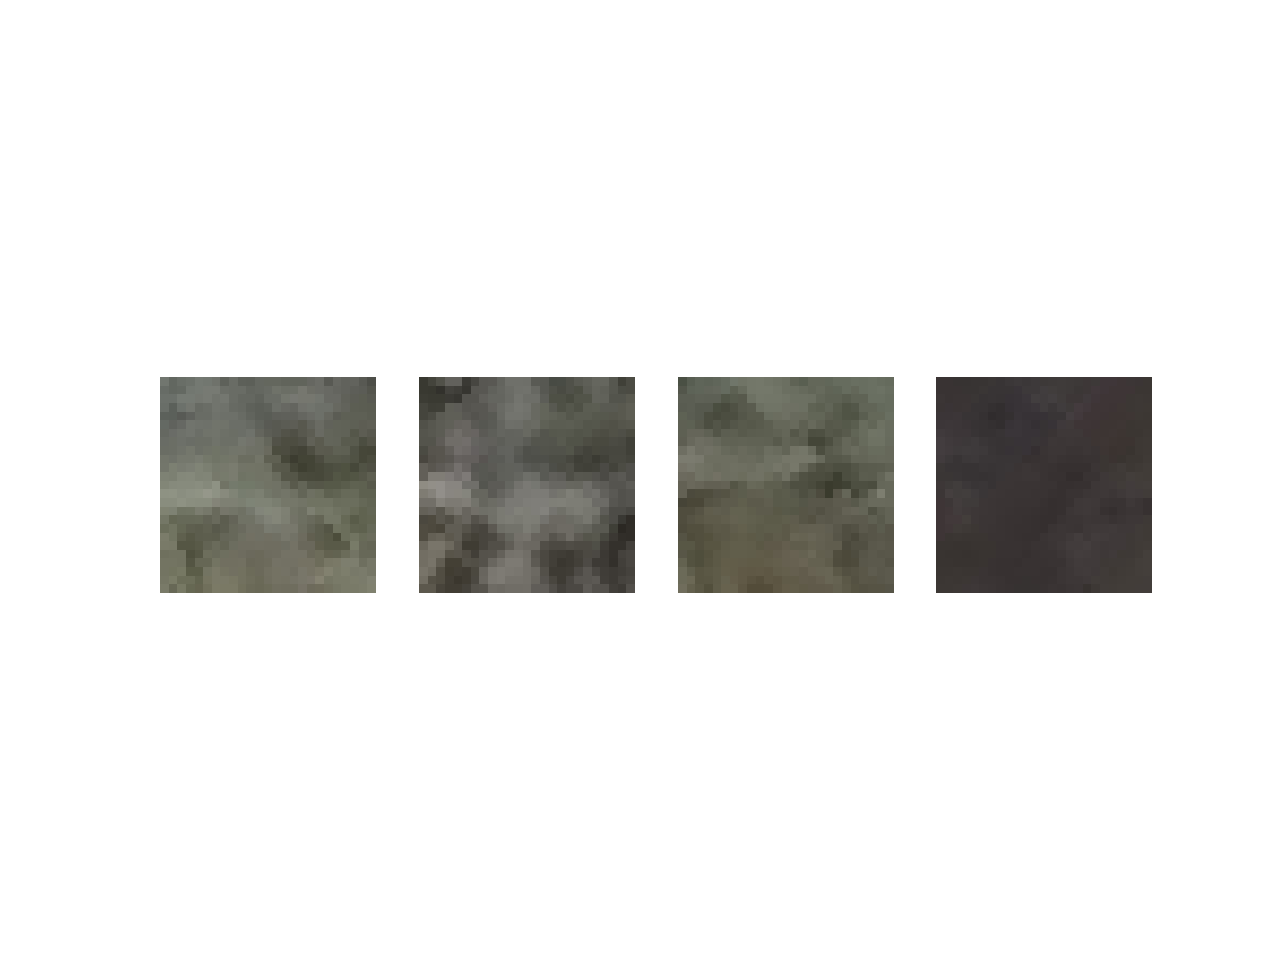

Training dataset dimensions:  (80000, 25, 25, 3) Training labels dimensions:  (80000, 1)
Validation dataset dimensions:  (10000, 25, 25, 3) Validation labels dimensions:  (10000, 1)
Test dataset dimensions:  (10000, 25, 25, 3) Test labels dimensions:  (10000, 1)


In [3]:
num_classes = 4
image_size = 25
transect1_path = '../Images/Transect 1 Hi-Res.tiff'
transect1_truth_path = '../Images/Transect 1 Truth data.tif'
Transect1, Transect1_truth = load_data(transect1_path, transect1_truth_path, truth_key=[16,160,198,38])
train_datasets, train_labels, valid_datasets, valid_labels, test_datasets, test_labels = \
    generate_training(Transect1, Transect1_truth, image_size = image_size, toremove = 3, figureson=True)

print("Training dataset dimensions: ", train_datasets.shape, "Training labels dimensions: ", train_labels.shape)
print("Validation dataset dimensions: ", valid_datasets.shape, "Validation labels dimensions: ", valid_labels.shape)
print("Test dataset dimensions: ", test_datasets.shape, "Test labels dimensions: ", test_labels.shape)

model = Sequential()
batch_size = 32
epochs = 10

if train_labels.shape[-1] != num_classes:
    train_labels = keras.utils.to_categorical(train_labels, num_classes)
    valid_labels = keras.utils.to_categorical(valid_labels, num_classes)
    test_labels = keras.utils.to_categorical(test_labels, num_classes)

In [16]:

# datagen = ImageDataGenerator(featurewise_center = True,
#                             rescale = 1./255)
# datagen.fit(train_datasets)


# Model initiation
patch1_size = 5
stride1 = 1
patch2_size = 5
stride2 = 1
depth1 = 64
depth2 = 128
depth3 = 256
depth4 = 64
model.add(Conv2D(depth1, (patch1_size,patch1_size), strides=(stride1,stride1), activation='relu', 
                 kernel_initializer = TruncatedNormal(mean=0,stddev=0.1), input_shape=(image_size,image_size,3)))
model.add(Conv2D(depth2, (patch2_size,patch2_size), strides=(stride2,stride2), activation='relu', 
                 kernel_initializer = TruncatedNormal(mean=0,stddev=0.1)))
model.add(Flatten())
model.add(Dense(depth3, activation='relu', kernel_initializer = TruncatedNormal(mean=0,stddev=0.1)))
model.add(Dense(depth4, activation='relu', kernel_initializer = TruncatedNormal(mean=0,stddev=0.1)))
model.add(Dense(num_classes, activation = 'softmax', kernel_initializer = TruncatedNormal(mean=0,stddev=0.1)))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.fit(train_datasets, train_labels,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(valid_datasets, valid_labels))
score = model.evaluate(test_datasets, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#model.save('./firstKerasmodel.h5')

#sgd = SGD(lr = 0.01)
#model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
#model.fit_generator(datagen.flow(train_datasets,train_labels,batch_size=batch_size,seed=1), steps_per_epoch=1000, epochs=epochs)
#score = model.evaluate_generator(datagen.flow(valid_datasets,valid_labels, batch_size=batch_size), steps=5)

Train on 80000 samples, validate on 10000 samples
Epoch 1/10
80000/80000 [==============================] - 780s - loss: 0.3351 - acc: 0.8782 - val_loss: 0.2401 - val_acc: 0.9092
Epoch 2/10
80000/80000 [==============================] - 763s - loss: 0.2324 - acc: 0.9168 - val_loss: 0.2257 - val_acc: 0.9169
Epoch 3/10
80000/80000 [==============================] - 808s - loss: 0.2061 - acc: 0.9270 - val_loss: 0.2047 - val_acc: 0.9283
Epoch 4/10
80000/80000 [==============================] - 752s - loss: 0.1903 - acc: 0.9318 - val_loss: 0.2096 - val_acc: 0.9254
Epoch 5/10
80000/80000 [==============================] - 751s - loss: 0.1761 - acc: 0.9378 - val_loss: 0.2112 - val_acc: 0.9250
Epoch 6/10
80000/80000 [==============================] - 747s - loss: 0.1623 - acc: 0.9427 - val_loss: 0.2049 - val_acc: 0.9302
Epoch 7/10
80000/80000 [==============================] - 746s - loss: 0.1512 - acc: 0.9466 - val_loss: 0.2229 - val_acc: 0.9275
Epoch 8/10
80000/80000 [=======================

In [26]:
model = load_model('firstKerasmodel.h5')

def load_whole_data(img1, img1_truth, image_size, depth=255, offset=0, lines=None, toremove = False):
    crop_len = int(np.floor(image_size/2))
    
    if lines is None:
        lines = img1.shape[0]-2*crop_len
    
    if offset + lines + 2*crop_len > img1.shape[0]:
        print("Too many lines specified, reverting to maximum possible")
        lines = im1.shape[0] - offset - 2*crop_len
    
    whole_datasets = []
    whole_labels = []
    for i in range(offset+crop_len,lines+offset+crop_len):
        for j in range(crop_len, img1.shape[1]-crop_len):
            whole_datasets.append(img1[i-crop_len:i+crop_len+1, j-crop_len:j+crop_len+1,:])
            whole_labels.append(img1_truth[i,j])
            
    whole_datasets = np.asarray(whole_datasets) 
    whole_labels = np.asarray(whole_labels).reshape((len(whole_labels),1))
    
    if toremove is not None:
        whole_datasets = np.delete(whole_datasets,toremove,-1) # Remove specific last dimension of array
    
    whole_dataset = rescale(whole_datasets,depth)
    return whole_dataset, whole_labels

def classifyback(predictions):
    return np.argmax(predictions,1)

whole_predict = []
offstart = 0
crop_len = int(np.floor(image_size/2))
num_lines = Transect1_truth.shape[0] - 2*crop_len
for offset in range(offstart,offstart+num_lines):
    if (offset % 100 == 0):
        print('Now on step %d ' offset)
    temp_dataset, temp_labelset = load_whole_data(Transect1, Transect1_truth, image_size=25, offset = offset, lines=1, toremove=3)
    temp_predict = model.predict_on_batch(temp_dataset)
    whole_predict.append(classifyback(temp_predict))

whole_predict = np.asarray(whole_predict)
print(whole_predict.shape)

(100, 2981)


In [27]:
truth_predict = Transect1_truth[crop_len+offstart:crop_len+offstart+num_lines, crop_len:Transect1_truth.shape[1]-crop_len]
accuracy = 100*(whole_predict == truth_predict).sum()/(whole_predict.shape[0]*whole_predict.shape[1])
print('Final Accuracy %.1f%%' % (accuracy))

Final Accuracy 92.2%


<IPython.core.display.Javascript object>


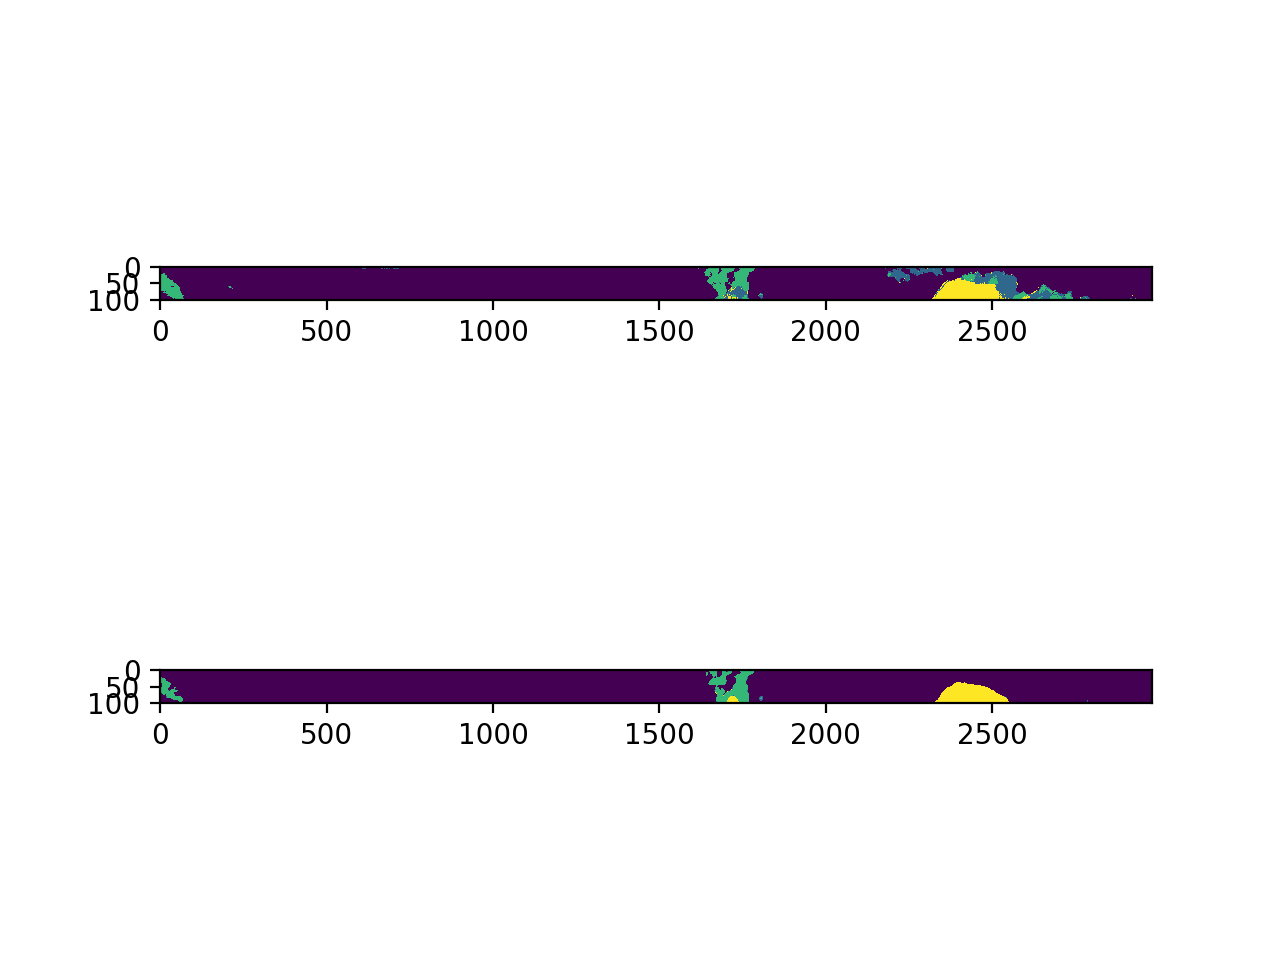

In [28]:
plt.figure()
plt.subplot(2,1,1)
plt.imshow(whole_predict)
# plt.axis('off')
plt.subplot(2,1,2)
plt.imshow(truth_predict)
# plt.axis('off')
plt.show()

In [29]:
print(Transect1_truth.shape)

(13598, 3005)
